# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

/home/alexm/anaconda3/envs/sdd_env/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


# Recupération des données

In [2]:
df = pd.read_csv("data/train.csv", sep=',')

In [3]:
df.columns[159]

'PSASUGST'

In [4]:

A_garder = ['CRVCLHPV', 'HADHYST2', 'COLNSIGM', "COLNCNCR", 'VIRCOLO1', "SMALSTOL", 'STOOLDN2', 'SMOKE100', 'SMOKDAY2',
            'USENOW3', 'ECIGNOW2', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'LCSCTSC1', 'LCSSCNCR', 'ALCDAY4', 'AVEDRNK3',
            'DRNK3GE5', "MAXDRNKS", 'HIVRISK5', 'COVIDPOS', 'COVIDSMP', 'COVIDPRM', 'PDIABTS1', 'PREDIAB2', 'DIABTYPE',
            'FEETSORE', 'TOLDCFS', 'HAVECFS', 'COPDCOGH', 'COPDFLEM', 'COPDBRTH', 'COPDBTST', 'COPDSMOK', 'CNCRDIFF', 
            'CSRVDOC1', 'CSRVDEIN', 'CSRVPAIN', 'CSRVCTL2', 'PSATEST1', 'PCPSARS2']

# BLDSTFIT = blood test en fonction d'avant un autre test
# 'COLNTES1', 'HADSIGM4', "SIGMTES1", 'LASTSIG4', 'VCLNTES2', 'STOLTEST', 'SDNATES1', 'LCSCTWHN', 'HIVTSTD3, COVIDFS1, COVIDSE1, PSATIME1 : date des teste
# 'FLUSHOT7', 'FLSHTMY3', 'PNEUVAC4', 'HIVTST7, 'IMFVPLA3, HPVADVC4, HPVADSHT, COVIDVA1  : vaccins
peut_etre = ['COLNTES1', 'HADSIGM4', "SIGMTES1", 'LASTSIG4', 'VCLNTES2', 'STOLTEST', 'SDNATES1', 'LCSCTWHN', 'BLDSTFIT', 
             'FLUSHOT7', 'FLSHTMY3', 'PNEUVAC4', 'TETANUS1', 'HIVTST7', 'HIVTSTD3', 'IMFVPLA3', 'HPVADVC4', 'HPVADSHT',
             'SHINGLE2', 'COVIDVA1', 'COVIDNU1', 'COVIDFS1', 'COVIDSE1', 'PSATIME1'] 

A_enlever = ['INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'DIABEDU1', 'WORKCFS', 'CSRVSUM', 'CSRVRTRN', 'CSRVINST',
             'CSRVINSR', 'CSRVCLIN', 'PSASUGST']

In [5]:
def plot_nan_proportion(df):
    """
    Affiche la proportion de valeurs manquantes (NaN) pour chaque colonne d'un DataFrame.
    """
    nan_proportion = df.isna().sum().sort_values(ascending=False) / len(df)

    plt.figure(figsize=(12, 6))
    plt.bar(nan_proportion.index, nan_proportion.values)
    plt.xticks(rotation=90)
    plt.ylabel("Proportion de NaN")
    plt.title("Proportion de valeurs manquantes par colonne")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    return nan_proportion

In [21]:
import yaml

with open('features.yaml', "r", encoding="utf-8") as yaml_file:
    yaml_content = yaml.load(yaml_file, Loader=yaml.SafeLoader)   

features = yaml_content['features']

In [7]:
df_clean = df[features]

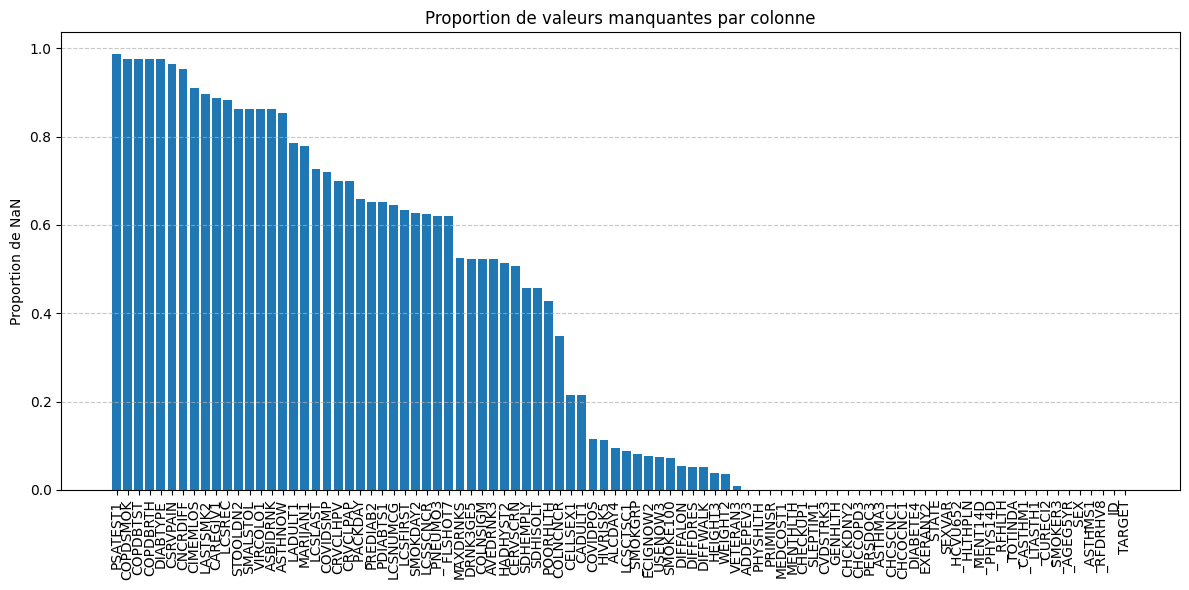

In [8]:
nan_proportion = plot_nan_proportion(df_clean)

In [9]:
def clean_data(df, suppr):

    for col in df.columns:
        if col in suppr:
            df = df.drop(col, axis = 1)
            
    nan_proportion = df.isna().sum().sort_values(ascending=False) / len(df)
    
    for i, prop in enumerate(nan_proportion.values):
        if prop > 0.90:
            print(nan_proportion.index[i])

    return df



In [10]:
A_supprimer = ["TOLDCFS", 'HAVECFS', 'COLGSEX1', 'CSRVCTL2', 'PCPSARS2', 'CSRVDEIN', 'CSRVDOC1', 'COPDFLEM', 'COPDCOGH',
               'FEETSORE', 'COVIDPRM', 'LANDSEX1']

A_clean = ["CSRVPAIN", 'PSATEST1', 'COPDSMOK', 'COPDBTST', 'COPDBRTH', 'DIABTYPE', 'CNCRDIFF', 'CIMEMLOS']

In [11]:
df_clean = clean_data(df_clean, A_supprimer)

X = df_clean.drop('TARGET', axis=1)
y = df_clean['TARGET'].astype(int)

PSATEST1
COPDSMOK
COPDBTST
COPDBRTH
DIABTYPE
CSRVPAIN
CNCRDIFF
CIMEMLOS


In [12]:
xgb =  XGBClassifier(n_estimators=51)

xgb.fit(X, y)

y_pred = xgb.predict(X)
print(f1_score(y_pred, y))

0.2558130130615876


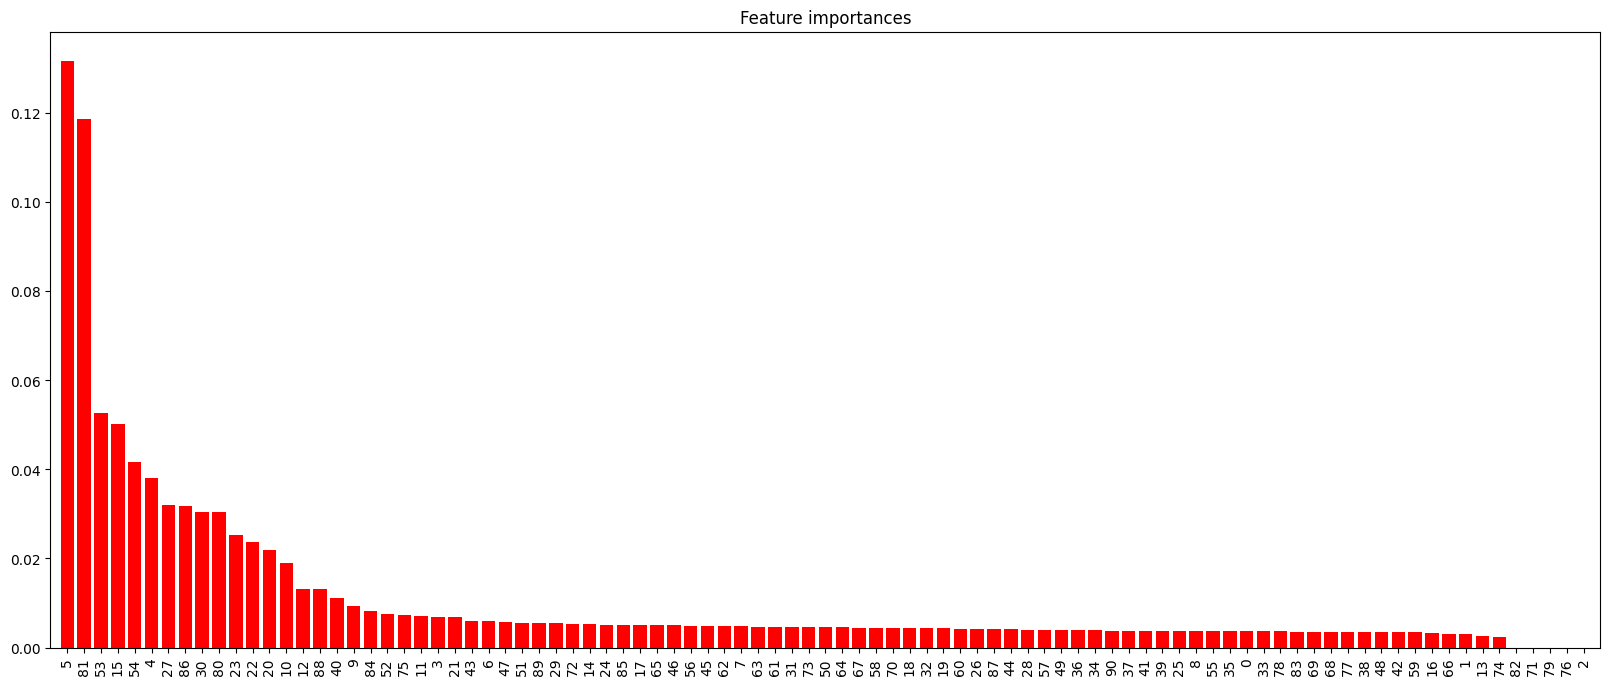

In [13]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=(20,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), indices, rotation = 90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [14]:
mi_cumsum = importances[indices].cumsum()
mi_total = importances[indices].sum()

threshold = 0.95 * mi_total
features_99 = mi_cumsum[mi_cumsum <= threshold]
indice = indices[mi_cumsum <= threshold]
print("Nombre de features conservées :", len(features_99))
print("Features conservées :", indice)

Nombre de features conservées : 70
Features conservées : [ 5 81 53 15 54  4 27 86 30 80 23 22 20 10 12 88 40  9 84 52 75 11  3 21
 43  6 47 51 89 29 72 14 24 85 17 65 46 56 45 62  7 63 61 31 73 50 64 67
 58 70 18 32 19 60 26 87 44 28 57 49 36 34 90 37 41 39 25  8 55 35]


In [15]:
X.shape

(225000, 91)

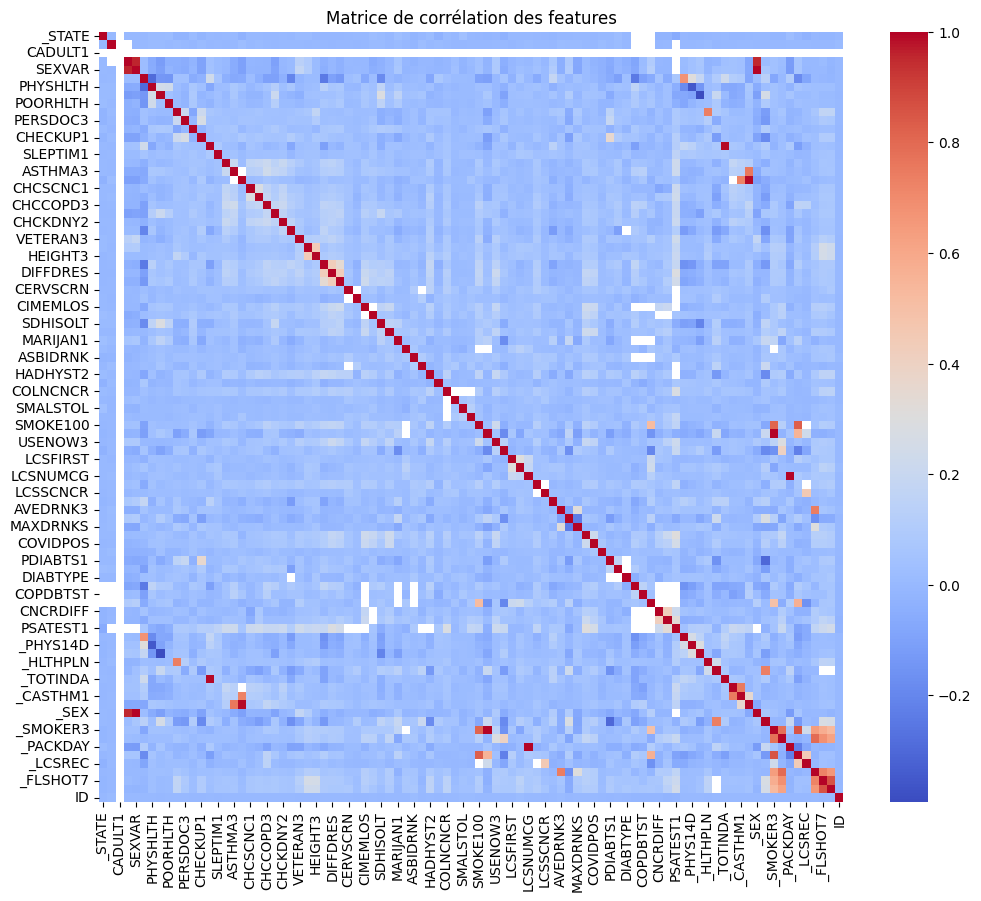

In [16]:
corr = X.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Matrice de corrélation des features")
plt.show()

In [17]:
for i in range(len(corr.values)):
    for j in range(i, len(corr.values[0])):
        if corr.values[i,j] > 0.9 and corr.values[i,j] != 1.0:
            print(f"forte corrélation entre {X.columns[i]} et {X.columns[j]}")

forte corrélation entre CELLSEX1 et SEXVAR
forte corrélation entre CELLSEX1 et _SEX
forte corrélation entre SEXVAR et _SEX
forte corrélation entre EXERANY2 et _TOTINDA
forte corrélation entre ASTHNOW et _ASTHMS1
forte corrélation entre SMOKDAY2 et _SMOKER3
forte corrélation entre LCSNUMCG et _PACKDAY


# Clean data

/tmp/ipykernel_52800/1867560441.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_clean[df_clean['TARGET']==0.0][id], bins = 30, ax = axes[0], kde = False)
/tmp/ipykernel_52800/1867560441.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_clean[df_clean['TARGET']==1.0][id], bi

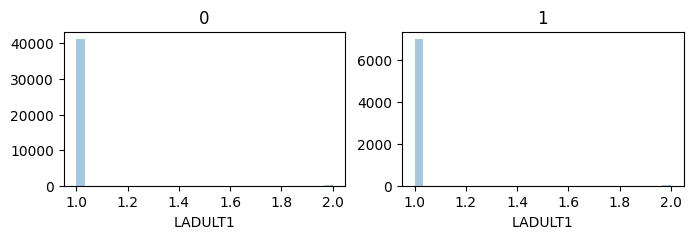

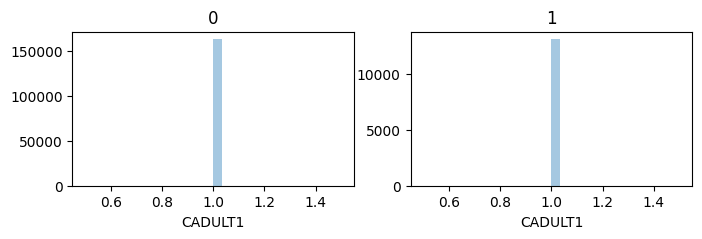

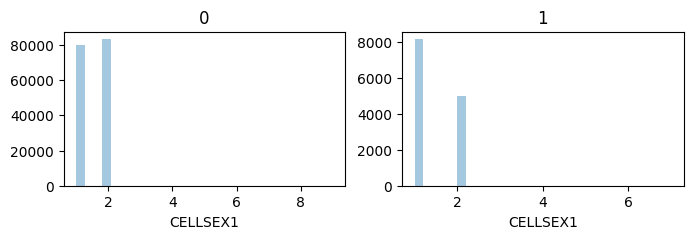

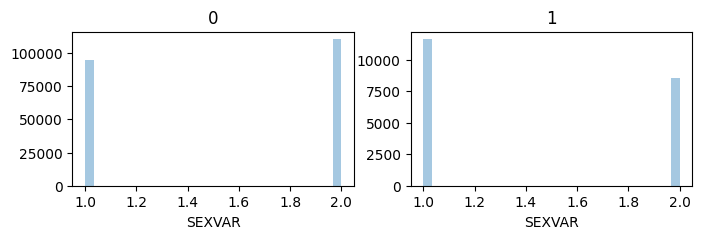

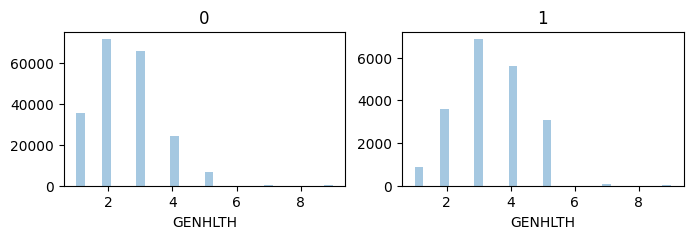

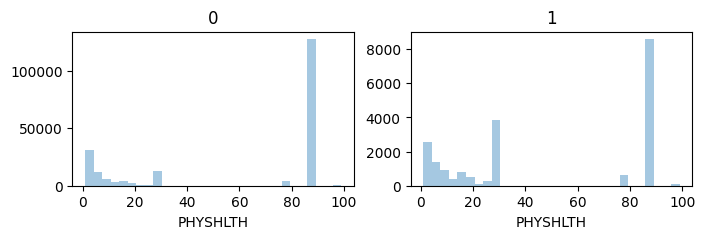

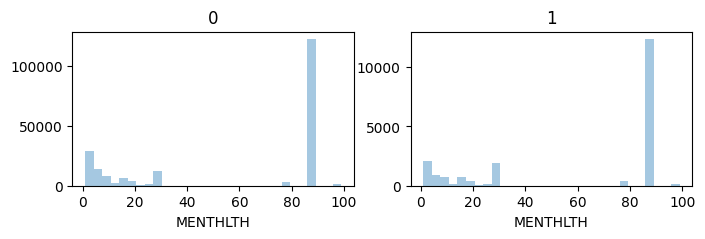

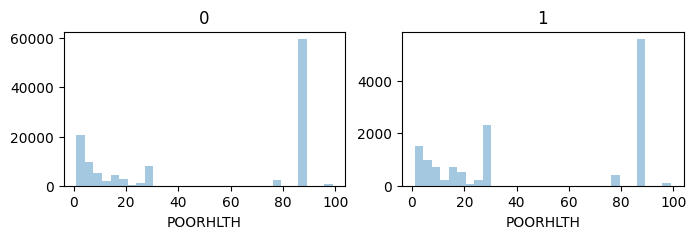

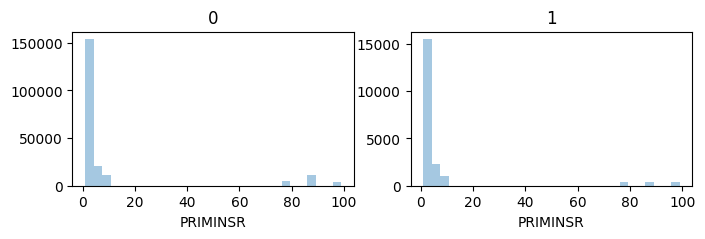

In [22]:
for i in range(1,10):
    id = features[i]
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8, 2))

    ax = sns.distplot(df_clean[df_clean['TARGET']==0.0][id], bins = 30, ax = axes[0], kde = False)
    ax.set_title('0')
    ax = sns.distplot(df_clean[df_clean['TARGET']==1.0][id], bins = 30, ax = axes[1], kde = False)
    ax.set_title('1')
plt.show()

In [6]:
from utils import HTMLParser
import yaml

parser = HTMLParser()
html_snippet = "data/USCODE22_LLCP_102523.HTML"

codebook = parser.parse_html_codebook(html_snippet)

In [4]:
data = pd.read_csv("data/train.csv")

In [7]:
config = "features.yaml"

with open(config, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

data_reduced = data[config['features'] + ['TARGET'] + ["ID"]].copy()

In [18]:
numerical = []
categorielle = []

for feature in config['features']:
    entry = next((item for item in codebook if item["sas_variable"] == feature), None)
    if entry:
        if entry["categories"][0]['value'] != '1':
            numerical.append(feature)
        else:
            categorielle.append(feature)


In [22]:
categorielle

['_STATE',
 'GENHLTH',
 'PRIMINSR',
 'PERSDOC3',
 'MEDCOST1',
 'CHECKUP1',
 'EXERANY2',
 'CVDSTRK3',
 'CHCSCNC1',
 'CHCOCNC1',
 'CHCCOPD3',
 'ADDEPEV3',
 'CHCKDNY2',
 'DIABETE4',
 'VETERAN3',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'CERVSCRN',
 'CRVCLPAP',
 'CIMEMLOS',
 'CAREGIV1',
 'SDHISOLT',
 'SDHEMPLY',
 'LASTSMK2',
 'ASBIDRNK',
 'CRVCLHPV',
 'HADHYST2',
 'COLNSIGM',
 'COLNCNCR',
 'VIRCOLO1',
 'SMALSTOL',
 'STOOLDN2',
 'USENOW3',
 'ECIGNOW2',
 'LCSCTSC1',
 'LCSSCNCR',
 'HIVRISK5',
 'COVIDPOS',
 'COVIDSMP',
 'PDIABTS1',
 'PREDIAB2',
 'DIABTYPE',
 'COPDBRTH',
 'COPDBTST',
 'CNCRDIFF',
 'CSRVPAIN',
 'PSATEST1',
 '_RFHLTH',
 '_PHYS14D',
 '_MENT14D',
 '_HLTHPLN',
 '_HCVU652',
 '_TOTINDA',
 '_ASTHMS1',
 '_SEX',
 '_AGEG5YR',
 '_CURECI2',
 '_SMOKGRP',
 '_LCSREC',
 '_RFDRHV8',
 '_FLSHOT7',
 '_PNEUMO3']

In [ ]:
def ft_in_to_cm(s):
    s = str(s).zfill(3)  
    feet = int(s[0])
    inches = int(s[1:])
    return feet * 30.48 + inches * 2.54

In [ ]:
case 'WEIGHT2':    
    df["WEIGHT2"] = df["WEIGHT2"].astype(float)
    mask_lb = df["WEIGHT2"].between(50, 776)
    df.loc[mask_lb, "WEIGHT2"] = df.loc[mask_lb, "WEIGHT2"] * 0.45359237

    mask_kg = df["WEIGHT2"].between(9023, 9352) 
    df.loc[mask_kg, "WEIGHT2"] = df.loc[mask_kg, "WEIGHT2"] - 9000


case 'HEIGHT3':
    mask_ft_in = df["HEIGHT3"].astype(int).between(200, 711)
    df.loc[mask_ft_in, "HEIGHT3"] = df.loc[mask_ft_in, "HEIGHT3"].apply(ft_in_to_cm)

    mask_kg = df["HEIGHT3"].between(9061, 9998)  
    df.loc[mask_kg, "HEIGHT3"] = df.loc[mask_kg, "HEIGHT3"] - 9000
